In [1]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


#import lnPi.old
import lnPi.core2
import lnPi
import lnPi.stability

import lnPi.collectionlnpiutils



In [2]:
# function to convert from CH3 units to standard units

In [3]:
import json
kB = 1.3806503E-23 #J/K
Na = 6.02214199E23 #1/mol
kg = 1.66054E-27 #1/amu
hPlanck = 6.62606876E-34 #Js


def get_lnz(path):
    with open(path) as f:
        metadata = json.load(f)

    deBroglie = hPlanck/np.sqrt(2. * np.pi * (metadata["mass"]*kg) * kB * (metadata["T*"]*metadata["eps_kB"])) * 1.e10 #ang

    mu = metadata['mu*'] + 3. * metadata['T*'] * np.log(metadata["sigma"]/deBroglie)
    temp = metadata['T*']

    lnz = mu / temp
    
    return lnz, {'beta': 1.0 / temp, 'volume' : metadata['V*']}


In [4]:
#reload(lnPi.core2)

# Basics

In [5]:
# get meta data
lnz, state_kws = get_lnz('./T_1.50/metadata.json')
print(state_kws)

# read in potential energy
pe = pd.read_csv('./T_1.50/ljsf.t150.bulk.v512.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values


# create MaskedlnPi object
ref = lnPi.MaskedlnPi.from_table('./T_1.50/ljsf.t150.bulk.v512.r1.lnpi.dat', 
                                 fill_value=np.nan, 
                                 lnz=lnz,
                                 # state_kws needs to be defined if want to calculate some properties
                                 # down the road
                                 state_kws=state_kws, 
                                 # extra_kws is where you pass things which will be passed along to
                                 # new lnPis, like potential energy
                                 extra_kws={'PE':pe})


# zero out the max value.
# this is not neccessary, but not a bad idea either
ref = ref.zeromax()

# pad missing values of lnPi
# again, not usually needed, but can be important for 
# multicomponent lnPi's during segmenting
ref = ref.pad()

# create a phase_creator object.
# this provides some 
# factory functions for reweighting, and segmenting lnPi
phase_creator= lnPi.segment.PhaseCreator(nmax=1, nmax_peak=4, ref=ref, 
                                         merge_kws=dict(efac=0.8), 
                                         # if want to id phases based on some
                                         # callable, then set this.
                                         # the callable is passes a list of 
                                         # MaskedlnPi objects, and should return 
                                         # a list of phaseid 
                                         tag_phases=None
                                         #tag_phases=tag_phases2
                                        )

# choose a particular factory method for creating phases
build_phases = phase_creator.build_phases_mu([None])

{'beta': 0.6666666666666666, 'volume': 512.0}


In [6]:
ref2 = lnPi.core2.MaskedlnPiDelayed.from_table('./T_1.50/ljsf.t150.bulk.v512.r1.lnpi.dat', 
                                 fill_value=np.nan, 
                                 lnz=lnz, 
                                 # state_kws needs to be defined if want to calculate some properties
                                 # down the road
                                 state_kws=state_kws, 
                                 # extra_kws is where you pass things which will be passed along to
                                 # new lnPis, like potential energy
                                 extra_kws={'PE':pe}).zeromax().pad()


phase_creator2 = lnPi.segment.PhaseCreator(nmax=1, nmax_peak=4, ref=ref2, 
                                         merge_kws=dict(efac=0.8), 
                                         # if want to id phases based on some
                                         # callable, then set this.
                                         # the callable is passes a list of 
                                         # MaskedlnPi objects, and should return 
                                         # a list of phaseid 
                                         tag_phases=None
                                         #tag_phases=tag_phases2
                                        )

# choose a particular factory method for creating phases
build_phases2 = phase_creator2.build_phases_mu([None])


In [7]:
# for big builds, take advantage of progress bar, and parallel builds
lnzs = np.linspace(-10, 3.5, 2000)

# by default, progress bar hides itself after completion.  use context manager to keep it
# note that for this example (where only have a single phase), doesn't really make a difference
with lnPi.set_options(tqdm_leave=True, joblib_use=False):
    o = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)

In [8]:
# for big builds, take advantage of progress bar, and parallel builds
lnzs = np.linspace(-10, 3.5, 2000)

# by default, progress bar hides itself after completion.  use context manager to keep it
# note that for this example (where only have a single phase), doesn't really make a difference
with lnPi.set_options(tqdm_leave=True, joblib_use=False):
    o2 = lnPi.CollectionlnPi.from_builder(lnzs, build_phases2)

In [31]:
lnPi.core2._get_data.cache_info()

CacheInfo(hits=2014, misses=2014, maxsize=20, currsize=20)

In [30]:
o2[0]._mask is o2[-1]._mask

True

In [24]:
o[0]._data is o[-1]._data

False

# Canoncial properties

 * Canonical properties are attached to MaskedlnPi objects throught the xcan attribute. 
 * just pick one and go.  Same regardless of lnz choosen

In [6]:
# available properties
print([x for x in dir(ref.xce) if x[0] != '_'] )

['PE', 'PE_n', 'S', 'S_n', 'Z', 'betaE', 'betaE_n', 'betaF', 'betaF_n', 'betaOmega', 'betaOmega_n', 'betamu', 'betapV', 'dens', 'ncoords', 'ntot', 'nvec', 'pressure', 'table']


In [7]:
ref.xce.PE

<xarray.DataArray 'PE' (n_0: 436)>
array([ 4.24625620e-10,  4.24669240e-10, -2.10383180e-02, -6.30913420e-02,
       -1.26155330e-01, -2.10088750e-01, -3.15098970e-01, -4.40889100e-01,
       -5.87430510e-01, -7.54767220e-01, -9.42946170e-01, -1.15177910e+00,
       -1.38122290e+00, -1.63141220e+00, -1.90223770e+00, -2.19341440e+00,
       -2.50510510e+00, -2.83772240e+00, -3.19036470e+00, -3.56350760e+00,
       -3.95667120e+00, -4.37085400e+00, -4.80489680e+00, -5.25918280e+00,
       -5.73311950e+00, -6.22761210e+00, -6.74307860e+00, -7.27817610e+00,
       -7.83352370e+00, -8.40884300e+00, -9.00366290e+00, -9.61837500e+00,
       -1.02539710e+01, -1.09089070e+01, -1.15833870e+01, -1.22778620e+01,
       -1.29924880e+01, -1.37257660e+01, -1.44797250e+01, -1.52530150e+01,
       -1.60452280e+01, -1.68579200e+01, -1.76893770e+01, -1.85394190e+01,
       -1.94108940e+01, -2.03013630e+01, -2.12104750e+01, -2.21404380e+01,
       -2.30890340e+01, -2.40557820e+01, -2.50422300e+01, -2.60469000e+01,
       -2.70711480e+01, -2.81138650e+01, -2.91782170e+01, -3.02605020e+01,
       -3.13603210e+01, -3.24819980e+01, -3.36220380e+01, -3.47788770e+01,
       -3.59566590e+01, -3.71526740e+01, -3.83682500e+01, -3.96005400e+01,
       -4.08514470e+01, -4.21216630e+01, -4.34114380e+01, -4.47194350e+01,
       -4.60495320e+01, -4.73951580e+01, -4.87592790e+01, -5.01428450e+01,
       -5.15455320e+01, -5.29687060e+01, -5.44082710e+01, -5.58644250e+01,
       -5.73398830e+01, -5.88331090e+01, -6.03428840e+01, -6.18701230e+01,
       -6.34205810e+01, -6.49895560e+01, -6.65738950e+01, -6.81805500e+01,
       -6.98016880e+01, -7.14403650e+01, -7.30984310e+01, -7.47738180e+01,
       -7.64666410e+01, -7.81781490e+01, -7.99071790e+01, -8.16566570e+01,
       -8.34232250e+01, -8.52056730e+01, -8.70105200e+01, -8.88299810e+01,
       -9.06694050e+01, -9.25263540e+01, -9.43992240e+01, -9.62924980e+01,
       -9.82005250e+01, -1.00131450e+02, -1.02080640e+02, -1.04048370e+02,
       -1.06030660e+02, -1.08028360e+02, -1.10046990e+02, -1.12079690e+02,
       -1.14134680e+02, -1.16206370e+02, -1.18293470e+02, -1.20397940e+02,
       -1.22520700e+02, -1.24659970e+02, -1.26818230e+02, -1.28994770e+02,
       -1.31189810e+02, -1.33404610e+02, -1.35637120e+02, -1.37885530e+02,
       -1.40150390e+02, -1.42435360e+02, -1.44737680e+02, -1.47057860e+02,
       -1.49396560e+02, -1.51754420e+02, -1.54121740e+02, -1.56512380e+02,
       -1.58924140e+02, -1.61347300e+02, -1.63787950e+02, -1.66248250e+02,
       -1.68732530e+02, -1.71232130e+02, -1.73742380e+02, -1.76273590e+02,
       -1.78822400e+02, -1.81389190e+02, -1.83972580e+02, -1.86576090e+02,
       -1.89198280e+02, -1.91834940e+02, -1.94486260e+02, -1.97160560e+02,
       -1.99849150e+02, -2.02560050e+02, -2.05287130e+02, -2.08028970e+02,
       -2.10793880e+02, -2.13573840e+02, -2.16367450e+02, -2.19179980e+02,
       -2.22010970e+02, -2.24863990e+02, -2.27737870e+02, -2.30625950e+02,
       -2.33527690e+02, -2.36449700e+02, -2.39387790e+02, -2.42340680e+02,
       -2.45317680e+02, -2.48313130e+02, -2.51323780e+02, -2.54348760e+02,
       -2.57385930e+02, -2.60438180e+02, -2.63519600e+02, -2.66624090e+02,
       -2.69744980e+02, -2.72881310e+02, -2.76034670e+02, -2.79206670e+02,
       -2.82396420e+02, -2.85605760e+02, -2.88827800e+02, -2.92069550e+02,
       -2.95331100e+02, -2.98611160e+02, -3.01923530e+02, -3.05237400e+02,
       -3.08573520e+02, -3.11925300e+02, -3.15297370e+02, -3.18686140e+02,
       -3.22099370e+02, -3.25517600e+02, -3.28966460e+02, -3.32427660e+02,
       -3.35910000e+02, -3.39406940e+02, -3.42930410e+02, -3.46464210e+02,
       -3.50017850e+02, -3.53598200e+02, -3.57189760e+02, -3.60803870e+02,
       -3.64439200e+02, -3.68085310e+02, -3.71753820e+02, -3.75433840e+02,
       -3.79133660e+02, -3.82854510e+02, -3.86598170e+02, -3.90354170e+02,
       -3.94124100e+02, -3.97912310e+02, -4.01723060e+02, -4.05553410e+02,
       -4.09404250e+02, -4.13272690e+02, -4.17160020e+02, -4.2106

In [8]:
ref.xce.betaF()

<xarray.DataArray 'betaF' (n_0: 436)>
array([   0.        ,   -6.23817948,  -11.78825896,  -16.93743845,
        -21.80391793,  -26.45169741,  -30.92217689,  -35.24305637,
        -39.43488586,  -43.51427534,  -47.49263482,  -51.3802843 ,
        -55.18540378,  -58.91534327,  -62.57494275,  -66.17037223,
        -69.70504171,  -73.18350119,  -76.61015068,  -79.98718016,
        -83.31692964,  -86.60257912,  -89.8454786 ,  -93.04802809,
        -96.21263757,  -99.34036705, -102.43368653, -105.49306601,
       -108.5203955 , -111.51717498, -114.48366446, -117.42170394,
       -120.33183342, -123.21554291, -126.07309239, -128.90524187,
       -131.71352135, -134.49843083, -137.26048032, -140.0003198 ,
       -142.71866928, -145.41596876, -148.09328824, -150.75033773,
       -153.38838721, -156.00779669, -158.60911617, -161.19235565,
       -163.75846514, -166.30706462, -168.8393841 , -171.35487358,
       -173.85522306, -176.33899255, -178.80819203, -181.26244151,
       -183.70210099, -186.12725047, -188.53863996, -190.93596944,
       -193.32005892, -195.6906584 , -198.04822788, -200.39366737,
       -202.72645685, -205.04623633, -207.35395581, -209.64960529,
       -211.93391478, -214.20585426, -216.46667374, -218.71597322,
       -220.9550527 , -223.18332219, -225.40031167, -227.60704115,
       -229.80326063, -231.98917011, -234.1650796 , -236.33078908,
       -238.48702856, -240.63264804, -242.76955752, -244.89666701,
       -247.01438649, -249.12308597, -251.22361545, -253.31480493,
       -255.39595442, -257.4689539 , -259.53255338, -261.58845286,
       -263.63558234, -265.67398183, -267.70434131, -269.72650079,
       -271.73953027, -273.74440975, -275.74137924, -277.73101872,
       -279.7130782 , -281.68591768, -283.65157717, -285.61055665,
       -287.56105613, -289.50371561, -291.44049509, -293.36790458,
       -295.28846406, -297.20126354, -299.10735302, -301.0055225 ,
       -302.89707199, -304.78059147, -306.65821095, -308.52848043,
       -310.39206991, -312.2488894 , -314.09815888, -315.94081836,
       -317.77650784, -319.60502732, -321.42745681, -323.24229629,
       -325.05055577, -326.85194525, -328.64783473, -330.43666422,
       -332.2189537 , -333.99419318, -335.76363266, -337.52592214,
       -339.28297163, -341.03243111, -342.77390059, -344.50930007,
       -346.23929955, -347.96371904, -349.68050852, -351.391878  ,
       -353.09613748, -354.79447696, -356.48639645, -358.17182593,
       -359.85110541, -361.52350489, -363.19123437, -364.85150386,
       -366.50556334, -368.15326282, -369.7945723 , -371.43032178,
       -373.05936127, -374.68213075, -376.29940023, -377.91152971,
       -379.51631919, -381.11453868, -382.70713816, -384.29292764,
       -385.87274712, -387.4464166 , -389.01376609, -390.57371557,
       -392.12786505, -393.67576453, -395.21820401, -396.7534535 ,
       -398.28227298, -399.80520246, -401.32196194, -402.83313142,
       -404.33591091, -405.83388039, -407.32500987, -408.80948935,
       -410.28982883, -411.76216832, -413.2288778 , -414.68839728,
       -416.14124676, -417.58711624, -419.02756573, -420.46151521,
       -421.88893469, -423.30869417, -424.72365365, -426.13137314,
       -427.53156262, -428.9252721 , -430.31202158, -431.69230106,
       -433.06684655, -434.43431703, -435.79411951, -437.14626999,
       -438.49252547, -439.83191996, -441.16547644, -442.49120992,
       -443.8104844 , -445.12238188, -446.42774437, -447.72567885,
       -449.01659133, -450.30019481, -451.57676529, -452.84530978,
       -454.10861026, -455.36379874, -456.61085822, -457.8521547 ,
       -459.08419335, -460.30921017, -461.5267044 , -462.73702688,
       -463.93941002, -465.1343495 , -466.32124898, -467.50068846,
       -468.67257795, -469.83581743, -470.99124691, -472.13908639,
       -473.27914587, -474.41150536, -475.53547484, -476.65090432,
       -477.7575738 , -478.85616328, -479.94691277, -481.02941225,
       -482.10285173, -483.16792121, -484.22480069, -485.27151018,
       -4

In [9]:
# table of properties
ref.xce.table(keys=['PE'], 
              # has default keys which can be set with
              # default_keys=[...]
             )

<xarray.Dataset>
Dimensions:  (component: 1, n_0: 436)
Coordinates:
  * n_0      (n_0) int64 0 1 2 3 4 5 6 7 8 ... 428 429 430 431 432 433 434 435
    beta     float64 0.6667
    volume   float64 512.0
Dimensions without coordinates: component
Data variables:
    PE       (n_0) float64 4.246e-10 4.247e-10 ... -1.649e+03 -1.654e+03
    betamu   (component, n_0) float64 -6.238 -5.894 -5.35 ... 3.747 3.801 3.831
    betapV   (n_0) float64 -0.0 0.344 1.089 ... 1.975e+03 1.998e+03 2.011e+03
    PE_n     (n_0) float64 inf 4.247e-10 -0.01052 ... -3.795 -3.799 -3.803
    betaF_n  (n_0) float64 nan -6.238 -5.894 -5.646 ... -0.8139 -0.8034 -0.7927

# Collection of lnPi's

In [16]:
# for big builds, take advantage of progress bar, and parallel builds
lnzs = np.linspace(-10, 3.5, 2000)

# by default, progress bar hides itself after completion.  use context manager to keep it
# note that for this example (where only have a single phase), doesn't really make a difference
with lnPi.set_options(tqdm_leave=True, joblib_use=False):
    o = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)

In [11]:
with lnPi.set_options(tqdm_leave=True):
    o.xge.pi_norm

# grand canonical properties

* Grand canonical properties are attached to CollectionlnPi objects. 
* Behind the scense, are master xarray.DataArray of lnPi's is created (x.xgce.lnpi).  This is not cached
* Pi(N) (attribute x.xgce.pi_norm) is cached for fast future calculations
* So the time consuming parti is creation of Pi(N), but further calcs are very fast

In [12]:
# available attributes/methods
print([x for x in dir(o.xge) if x[0] != '_'])

['PE', 'PE_n', 'S', 'S_n', 'Z', 'argmax', 'beta', 'betaE', 'betaE_n', 'betaF', 'betaF_alt', 'betaF_n', 'betaG', 'betaG_n', 'betaOmega', 'betaOmega_n', 'betamu', 'betapV', 'coords_state', 'dens', 'dens_tot', 'dims_comp', 'dims_lnz', 'dims_n', 'dims_rec', 'dims_state', 'edge_distance', 'lnpi', 'lnpi_norm', 'lnz', 'mask_stable', 'max', 'mean_pi', 'molfrac', 'ncoords', 'ncoords_tot', 'ntot', 'ntot_var', 'nvec', 'nvec_var', 'pi_norm', 'pi_sum', 'pipe', 'pressure', 'table', 'var_pi', 'volume']


In [13]:
o.xge.betaOmega()

<xarray.DataArray 'betaOmega' (lnz_0: 2000, phase: 1)>
array([[-2.32427562e-02],
       [-2.34002638e-02],
       [-2.35588389e-02],
       ...,
       [-1.86516098e+03],
       [-1.86804678e+03],
       [-1.87093336e+03]])
Coordinates:
    beta     float64 0.6667
    volume   float64 512.0
  * lnz_0    (lnz_0) float64 -10.0 -9.993 -9.986 -9.98 ... 3.48 3.486 3.493 3.5
  * phase    (phase) int64 0
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'beta', 'volume']
    dims_rec:       ['sample']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [14]:
# table
o.xge.table(keys=['PE', 'dens'], 
            # by setting ref, calculate edge distance for each sample
            ref=ref,
            # by setting mask_stable, return only the stable phase
            mask_stable=True,
           )

<xarray.Dataset>
Dimensions:        (component: 1, lnz_0: 2000)
Coordinates:
    beta           float64 0.6667
    volume         float64 512.0
  * lnz_0          (lnz_0) float64 -10.0 -9.993 -9.986 -9.98 ... 3.486 3.493 3.5
Dimensions without coordinates: component
Data variables:
    edge_distance  (lnz_0) float64 436.0 436.0 436.0 436.0 ... 9.0 8.0 8.0 8.0
    PE             (lnz_0) float64 -5.712e-06 -5.789e-06 ... -1.612e+03
    dens           (component, lnz_0) float64 4.54e-05 4.571e-05 ... 0.8349
    nvec           (component, lnz_0) float64 0.02324 0.0234 ... 427.4 427.5
    betapV         (lnz_0) float64 0.02324 0.0234 ... 1.868e+03 1.871e+03
    PE_n           (lnz_0) float64 -0.0002457 -0.0002474 ... -3.769 -3.77
    phase          (lnz_0) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

# comparison xcan/xgce

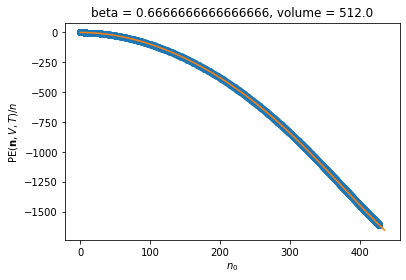

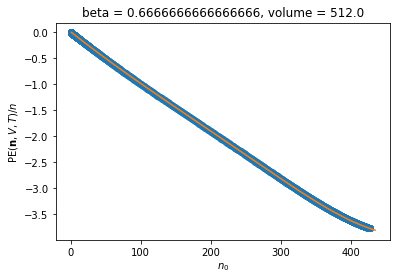

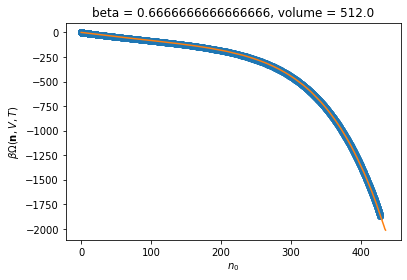

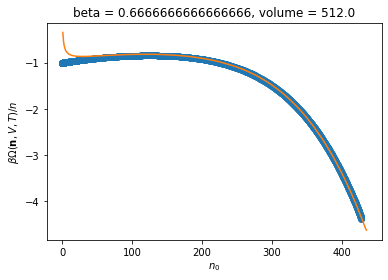

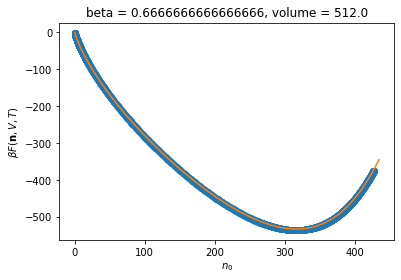

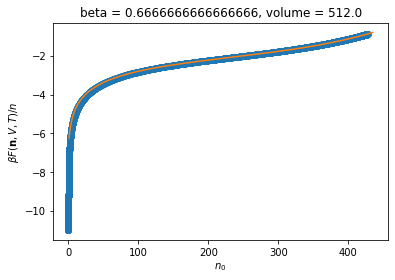

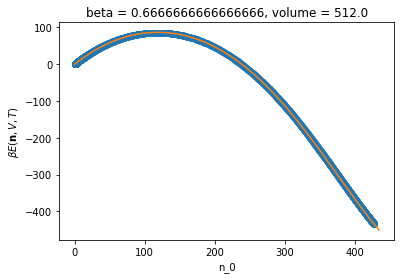

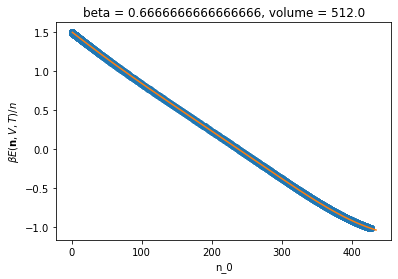

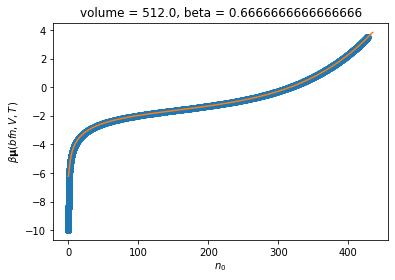

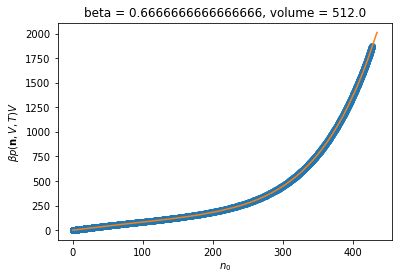

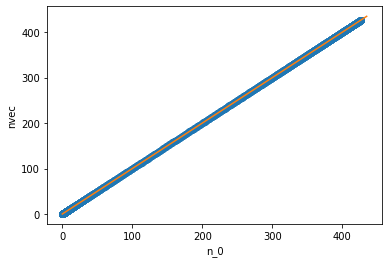

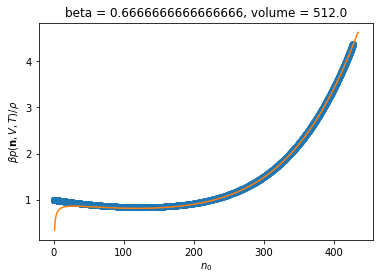

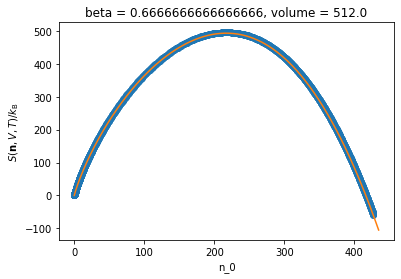

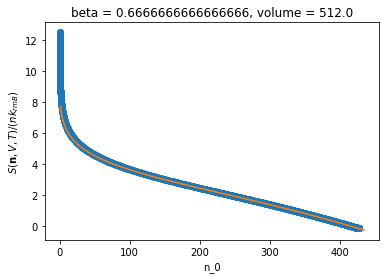

In [17]:
for prop in ['PE','PE_n', 'betaOmega', 'betaOmega_n', 'betaF', 'betaF_n', 'betaE','betaE_n', 'betamu', 'betapV',
             'nvec','Z', 'S','S_n']:

    fig, ax = plt.subplots()
    (
        o.xge.table(['ntot',prop], default_keys=[]).min('phase')
        .set_coords('ntot')
        .swap_dims({'lnz_0':'ntot'})
        [prop]
        .plot(label='grand canonical', marker='o')
    )

    (
        ref.xce.table([prop], default_keys=[])
        [prop]
        .plot()
    )

# comparison to old results

In [18]:
df = (
    pd.read_csv('./T_1.50_EOS.csv')
    .rename(columns=lambda x: x.replace('*','').replace('<','').replace('>','').replace(')','').replace('(',''))
    .rename(columns={'lnz':'lnz_0','rho':'dens','p':'pressure','U':'PE'})
)
    
df.head()

,T,V,Rcut,TAIL,lnz_0,dens,stdev,pressure,stdev.1,PE,stdev.2
0,1.5,512.0,2.5,LFS,-6.910147,0.00100,3.196241e-08,0.001498,8.859471e-08,-0.002772,0.000002
1,1.5,512.0,2.5,LFS,-6.900367,0.00101,3.193346e-08,0.001513,8.900519e-08,-0.002827,0.000002
2,1.5,512.0,2.5,LFS,-6.890587,0.00102,3.190516e-08,0.001528,8.941257e-08,-0.002882,0.000002
3,1.5,512.0,2.5,LFS,-6.880808,0.00103,3.187785e-08,0.001543,8.981673e-08,-0.002940,0.000002
4,1.5,512.0,2.5,LFS,-6.871028,0.00104,3.185190e-08,0.001558,9.021756e-08,-0.002998,0.000002


In [19]:
# build nice grid
import lnPi.collectionlnpiutils
o_course, o = lnPi.collectionlnpiutils.limited_collection(build_phases, dlnz=0.01, offsets=[-10, +10], 
                                                even_grid=True, # but lnzs on same grid as dlnz
                                                digits=2, #round lnzs to this number of digits
                                                edge_distance_min=10, dens_min=0.001)

In [20]:
table = (
    o.xge.table(['dens','pressure','PE','betamu'], default_keys=[], ref=ref)
    .sel(phase=0,component=0)
    .to_dataframe()
    .reset_index()
)

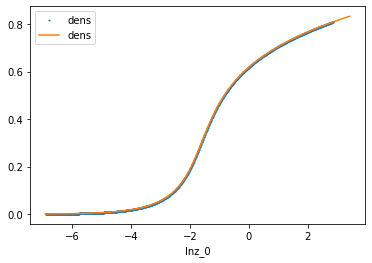

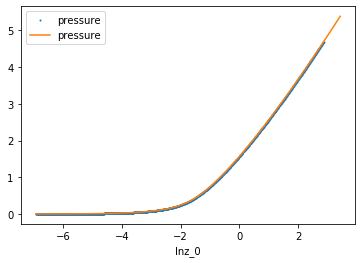

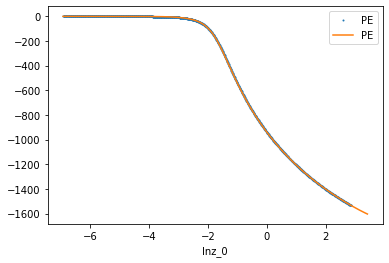

In [21]:
for col in ['dens','pressure','PE']:
    fig, ax = plt.subplots()
    df.plot('lnz_0',col, marker='o', mfc=None, ls='None', ax=ax, ms=1)
    table.plot('lnz_0',col, ax=ax, color='tab:orange')

# Multiple phases (sub critical)

In [90]:
reload(lnPi.segment)

/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.segment.wlnPivec'> under name 'wlnPi' for type <class 'lnPi.collectionlnpi.CollectionlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)
/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.segment.wlnPi_single'> under name 'wlnPi_single' for type <class 'lnPi.collectionlnpi.CollectionlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)


<module 'lnPi.segment' from '/Users/wpk/Documents/python/lnPi/segment.py'>

In [91]:
#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


In [92]:
# get meta data
lnz, state_kws = get_lnz('./T_0.72871/metadata.json')
pe = pd.read_csv('./T_0.72871/ljsf.t072871.bulk.v512.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values
ref = lnPi.MaskedlnPi.from_table('./T_0.72871/ljsf.t072871.bulk.v512.r1.lnpi.dat',
                                 fill_value=np.nan, 
                                 lnz=lnz,
                                 state_kws=state_kws, 
                                 extra_kws={'PE':pe}).zeromax().pad()


# Note that here, nmax=2, and we specify tag_phases
phase_creator= lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, 
                                         merge_kws=dict(efac=0.8), 
                                         tag_phases=tag_phases2
                                        )

# choose a particular factory method for creating phases
build_phases = phase_creator.build_phases_mu([None])

## parallel builds

In [93]:
lnzs = np.linspace(-10, 3, 2000)

In [ ]:
#slow
with lnPi.set_options(tqdm_leave=True, joblib_use=False):
    o = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)

In [94]:
#fast 
with lnPi.set_options(tqdm_leave=True, joblib_use=True):
    o = lnPi.CollectionlnPi.from_builder(lnzs, build_phases)

## stacked vs unstacked

In [25]:
lnzs = np.linspace(-10, 3, 20)

# unstack is default behavior
o_unstacked = lnPi.CollectionlnPi.from_builder(lnzs, build_phases, unstack=True)

# pass unstack = False
o_stacked = lnPi.CollectionlnPi.from_builder(lnzs, build_phases, unstack=False)

In [26]:
# unstack results
o_unstacked.xge.dens

<xarray.DataArray 'dens' (component: 1, lnz_0: 20, phase: 2)>
array([[[4.54122341e-05,            nan],
        [9.00659216e-05,            nan],
        [1.78724194e-04,            nan],
        [3.55037718e-04,            nan],
        [7.06808827e-04,            nan],
        [1.41324537e-03,            nan],
        [2.85107412e-03,            nan],
        [5.86258523e-03,            nan],
        [1.26156786e-02,            nan],
        [3.14809935e-02, 7.21258469e-01],
        [           nan, 7.69245441e-01],
        [           nan, 8.02630469e-01],
        [           nan, 8.29147738e-01],
        [           nan, 8.44711654e-01],
        [           nan, 8.48195862e-01],
        [           nan, 8.49053617e-01],
        [           nan, 8.49359302e-01],
        [           nan, 8.49489945e-01],
        [           nan, 8.49550725e-01],
        [           nan, 8.49580181e-01]]])
Coordinates:
    beta     float64 1.372
    volume   float64 512.0
  * lnz_0    (lnz_0) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [27]:
# stacked results
o_stacked.xge.dens

<xarray.DataArray 'dens' (sample: 21, component: 1)>
array([[4.54122341e-05],
       [9.00659216e-05],
       [1.78724194e-04],
       [3.55037718e-04],
       [7.06808827e-04],
       [1.41324537e-03],
       [2.85107412e-03],
       [5.86258523e-03],
       [1.26156786e-02],
       [3.14809935e-02],
       [7.21258469e-01],
       [7.69245441e-01],
       [8.02630469e-01],
       [8.29147738e-01],
       [8.44711654e-01],
       [8.48195862e-01],
       [8.49053617e-01],
       [8.49359302e-01],
       [8.49489945e-01],
       [8.49550725e-01],
       [8.49580181e-01]])
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
    beta     float64 1.372
    volume   float64 512.0
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [28]:
# its trivial to go from one to the other that to take an stacked array to unstacked
o_stacked.xge.dens.unstack()

<xarray.DataArray 'dens' (component: 1, lnz_0: 20, phase: 2)>
array([[[4.54122341e-05,            nan],
        [9.00659216e-05,            nan],
        [1.78724194e-04,            nan],
        [3.55037718e-04,            nan],
        [7.06808827e-04,            nan],
        [1.41324537e-03,            nan],
        [2.85107412e-03,            nan],
        [5.86258523e-03,            nan],
        [1.26156786e-02,            nan],
        [3.14809935e-02, 7.21258469e-01],
        [           nan, 7.69245441e-01],
        [           nan, 8.02630469e-01],
        [           nan, 8.29147738e-01],
        [           nan, 8.44711654e-01],
        [           nan, 8.48195862e-01],
        [           nan, 8.49053617e-01],
        [           nan, 8.49359302e-01],
        [           nan, 8.49489945e-01],
        [           nan, 8.49550725e-01],
        [           nan, 8.49580181e-01]]])
Coordinates:
    beta     float64 1.372
    volume   float64 512.0
  * lnz_0    (lnz_0) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [29]:
# note that xarray carries along nan
# and reorders on unstack.  No big deal
o_unstacked.xge.dens.stack(sample=['lnz_0','phase']).dropna('sample').transpose('sample','component')

<xarray.DataArray 'dens' (sample: 21, component: 1)>
array([[4.54122341e-05],
       [9.00659216e-05],
       [1.78724194e-04],
       [3.55037718e-04],
       [7.06808827e-04],
       [1.41324537e-03],
       [2.85107412e-03],
       [5.86258523e-03],
       [1.26156786e-02],
       [3.14809935e-02],
       [7.21258469e-01],
       [7.69245441e-01],
       [8.02630469e-01],
       [8.29147738e-01],
       [8.44711654e-01],
       [8.48195862e-01],
       [8.49053617e-01],
       [8.49359302e-01],
       [8.49489945e-01],
       [8.49550725e-01],
       [8.49580181e-01]])
Coordinates:
    beta     float64 1.372
    volume   float64 512.0
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -10.0 -9.316 -8.632 -7.947 ... 1.632 2.316 3.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [88]:
o[0].xge._wrapper

In [94]:
ref.xge._wrapper.ncoords().data is o.xge._wrapper.ncoords().data

True

In [87]:
ref.xge._wrapper

In [64]:
o.xge._cache = {}

In [65]:
%timeit -n 1 -r 1 o.xge.nvec

112 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [70]:
for x in o:
    x.xge._cache = {}

In [74]:
%timeit -n 1 -r 1 [x.xge.nvec for x in o]

2.86 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [80]:
%timeit -n 1 -r 1 pd.Series(out)

336 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [73]:
pd.Series([x.xge.nvec for x in o], o.index)

lnz_0       phase
-10.000000  0        [<xarray.DataArray 'nvec' ()>\narray(0.0232510...
-9.993497   0        [<xarray.DataArray 'nvec' ()>\narray(0.0234028...
-9.986993   0        [<xarray.DataArray 'nvec' ()>\narray(0.0235556...
-9.980490   0        [<xarray.DataArray 'nvec' ()>\narray(0.0237094...
-9.973987   0        [<xarray.DataArray 'nvec' ()>\narray(0.0238641...
                                           ...                        
 2.973987   1        [<xarray.DataArray 'nvec' ()>\narray(434.98465...
 2.980490   1        [<xarray.DataArray 'nvec' ()>\narray(434.98475...
 2.986993   1        [<xarray.DataArray 'nvec' ()>\narray(434.98485...
 2.993497   1        [<xarray.DataArray 'nvec' ()>\narray(434.98495...
 3.000000   1        [<xarray.DataArray 'nvec' ()>\narray(434.98505...
Length: 2138, dtype: object

## comparison 

In [39]:
# build nice grid
import lnPi.collectionlnpiutils

In [40]:
o_course, o = lnPi.collectionlnpiutils.limited_collection(build_phases, dlnz=0.01, offsets=[-10, +10], 
                                                even_grid=True, # but lnzs on same grid as dlnz
                                                digits=2, #round lnzs to this number of digits
                                                edge_distance_min=10, dens_min=0.001)

In [41]:
df = (
    pd.read_csv('./T_0.72871_EOS.csv')
    .rename(columns=lambda x: x.replace('*','').replace('<','').replace('>','').replace(')','').replace('(',''))
    .rename(columns={'lnz':'lnz_0','rho':'dens','p':'pressure','U':'PE'})
)
    
df.head()

,T,V,Rcut,TAIL,lnz_0,dens,stdev,pressure,stdev.1,PE,stdev.2
0,0.72871,512.0,2.5,LFS,-6.919759,0.001000,1.236298e-07,0.000724,9.518432e-08,-0.004397,0.000002
1,0.72871,512.0,2.5,LFS,-6.915094,0.001005,1.241497e-07,0.000728,9.559684e-08,-0.004439,0.000002
2,0.72871,512.0,2.5,LFS,-6.910429,0.001010,1.246715e-07,0.000731,9.601106e-08,-0.004481,0.000002
3,0.72871,512.0,2.5,LFS,-6.905764,0.001014,1.251954e-07,0.000735,9.642697e-08,-0.004523,0.000002
4,0.72871,512.0,2.5,LFS,-6.901100,0.001019,1.257213e-07,0.000738,9.684459e-08,-0.004566,0.000002


## picking stable phases

In [42]:
table = (
    o.xge.table(['dens','pressure','PE','betamu'], default_keys=[], ref=ref)
)

# note that now we have multiple phases.  want only the most stable phases...
table

<xarray.Dataset>
Dimensions:        (component: 1, lnz_0: 524, phase: 2)
Coordinates:
    beta           float64 1.372
    volume         float64 512.0
  * lnz_0          (lnz_0) float64 -6.92 -6.91 -6.9 -6.89 ... -1.71 -1.7 -1.69
  * phase          (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    edge_distance  (lnz_0, phase) float64 436.0 nan 436.0 nan ... 10.0 nan 10.0
    dens           (component, lnz_0, phase) float64 0.0009998 nan ... 0.8324
    pressure       (lnz_0, phase) float64 0.0007241 nan 0.0007314 ... nan 1.313
    PE             (lnz_0, phase) float64 -0.004394 nan ... nan -1.916e+03
    betamu         (component, lnz_0, phase) float64 -6.92 nan ... nan -1.69

In [43]:
table = (
    o.xge.table(['dens','pressure','PE','betamu'], mask_stable=True, default_keys=[], ref=ref)
    .to_dataframe()
    .reset_index()
)

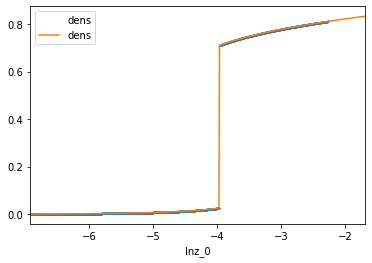

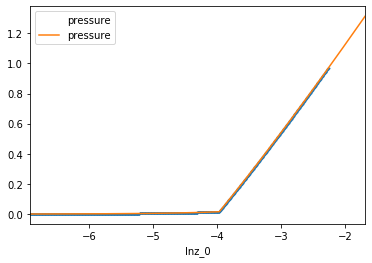

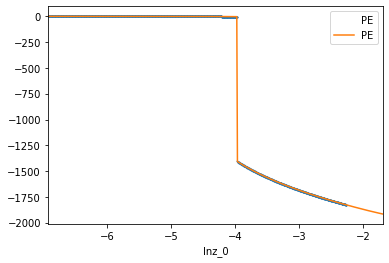

In [44]:
for col in ['dens','pressure','PE']:
    fig, ax = plt.subplots()
    df.plot('lnz_0',col, marker='o', mfc=None, ls='None', ax=ax, ms=1)
    table.plot('lnz_0',col, ax=ax, color='tab:orange')

# building stability

In [45]:
o_course.spinodal(2, build_phases)
o_course.binodal(2, build_phases)

In [46]:
o_course.spinodal.access

<class CollectionlnPi>
spinodal  lnz_0      phase
0         -3.494763  0        [-3.4947634419931606]
                     1        [-3.4947634419931606]
1         -4.379778  0         [-4.379778340306185]
                     1         [-4.379778340306185]
dtype: object

In [47]:
o_course.spinodal.access.wlnPi.dw

spinodal  lnz_0      phase  phase_nebr
0         -3.494763  0      0                    inf
                            1               1.000000
                     1      0             168.028142
                            1                    inf
1         -4.379778  0      0                    inf
                            1             142.163654
                     1      0               1.000000
                            1                    inf
Name: delta_w, dtype: float64

In [48]:
o_course.binodal.access.xge.betaOmega()

<xarray.DataArray 'betaOmega' (binodal: 1, lnz_0: 1, phase: 2)>
array([[[-11.201295, -11.201295]]])
Coordinates:
    beta     float64 1.372
    volume   float64 512.0
  * binodal  (binodal) int64 0
  * lnz_0    (lnz_0) float64 -3.966
  * phase    (phase) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'beta', 'volume']
    dims_rec:       ['sample']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [49]:
# append to o
o_new = o.stability_append(o_course)

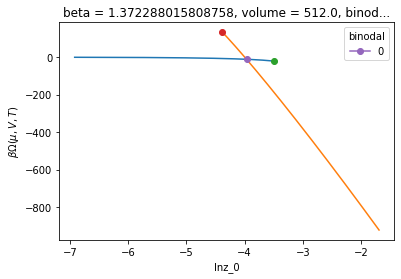

In [50]:
o_new.xge.betaOmega().plot(hue='phase')

(
    o_new.spinodal.access.xge.betaOmega()
    .pipe(lambda x: x.sel(spinodal=x.phase))
    .plot(hue='phase', marker='o')
)


(
    o_new.binodal.access.xge
    .betaOmega()
    .pipe(lambda x: x.sel(phase=x.binodal))
    .plot.line(hue='binodal', marker='o')
)